In [1]:
!python -m pip install -q keras-cv
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hojjatk/mnist-dataset
!unzip -q mnist-dataset.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.1/606.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.5 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
 36% 8.00M/22.0M [00:00<00:00, 81.2MB/s]
100% 22.0M/22.0M [00:00<00:00, 143MB/s] 


In [12]:
import numpy as np
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):

    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)


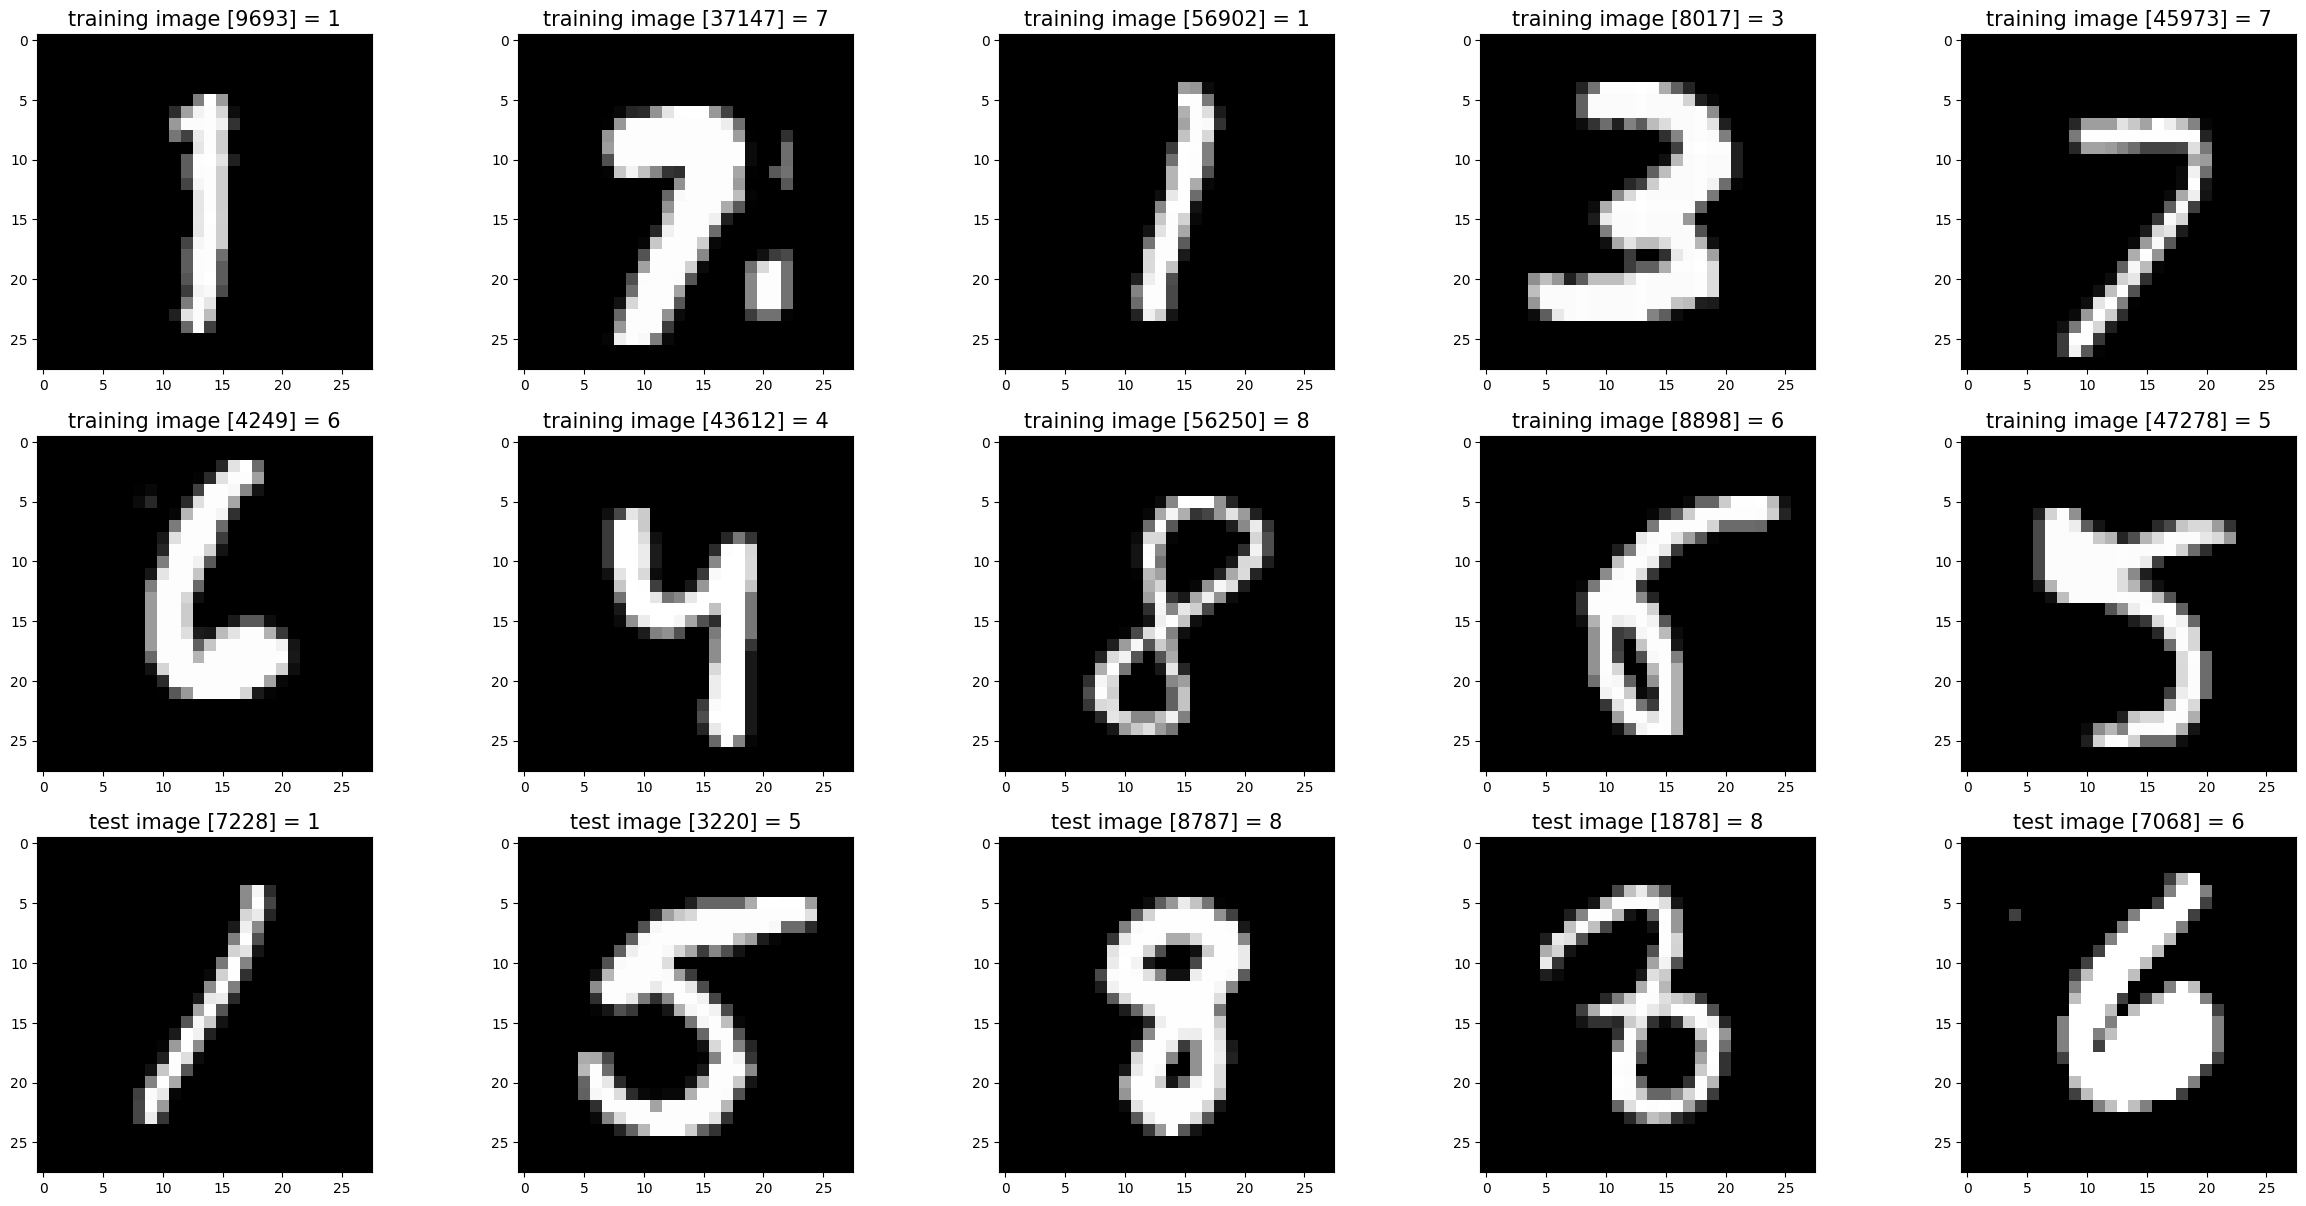

In [13]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../content'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)


In [34]:
x_train = np.expand_dims(np.array(x_train), axis=-1)
y_train = np.expand_dims(np.array(y_train), axis=-1)
x_test = np.expand_dims(np.array(x_test), axis=-1)
y_test = np.expand_dims(np.array(y_test), axis=-1)

In [70]:
import tensorflow as tf

LEARNING_RATE = 1e-2
REGULARIZATION = 5e-4

lenet = tf.keras.Sequential(layers=[
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=REGULARIZATION)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=tf.keras.regularizers.L2(l2=REGULARIZATION)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=140, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=REGULARIZATION)),
    tf.keras.layers.Dense(units=10)
])

lenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy()])

lenet.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 re_lu_50 (ReLU)             (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 14, 14, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 re_lu_51 (ReLU)             (None, 10, 10, 16)        0         
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                               

In [71]:
lenet.fit(x=x_train, y=y_train, batch_size=128, epochs=5, validation_split=0.25)

Epoch 1/5
352/352 [==============================] - 32s 88ms/step - loss: 1.5020 - sparse_categorical_accuracy: 0.8247 - val_loss: 0.3622 - val_sparse_categorical_accuracy: 0.9422
Epoch 2/5
352/352 [==============================] - 31s 88ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.2855 - val_sparse_categorical_accuracy: 0.9603
Epoch 3/5
352/352 [==============================] - 29s 81ms/step - loss: 0.2763 - sparse_categorical_accuracy: 0.9585 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.9600
Epoch 4/5
352/352 [==============================] - 29s 81ms/step - loss: 0.2492 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.2355 - val_sparse_categorical_accuracy: 0.9630
Epoch 5/5
352/352 [==============================] - 31s 88ms/step - loss: 0.2318 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.2238 - val_sparse_categorical_accuracy: 0.9660


In [72]:
y_test_pred = lenet.predict(x_test)

313/313 [==============================] - 4s 11ms/step


In [76]:
y_test_pred = np.argmax(y_test_pred, axis=-1)

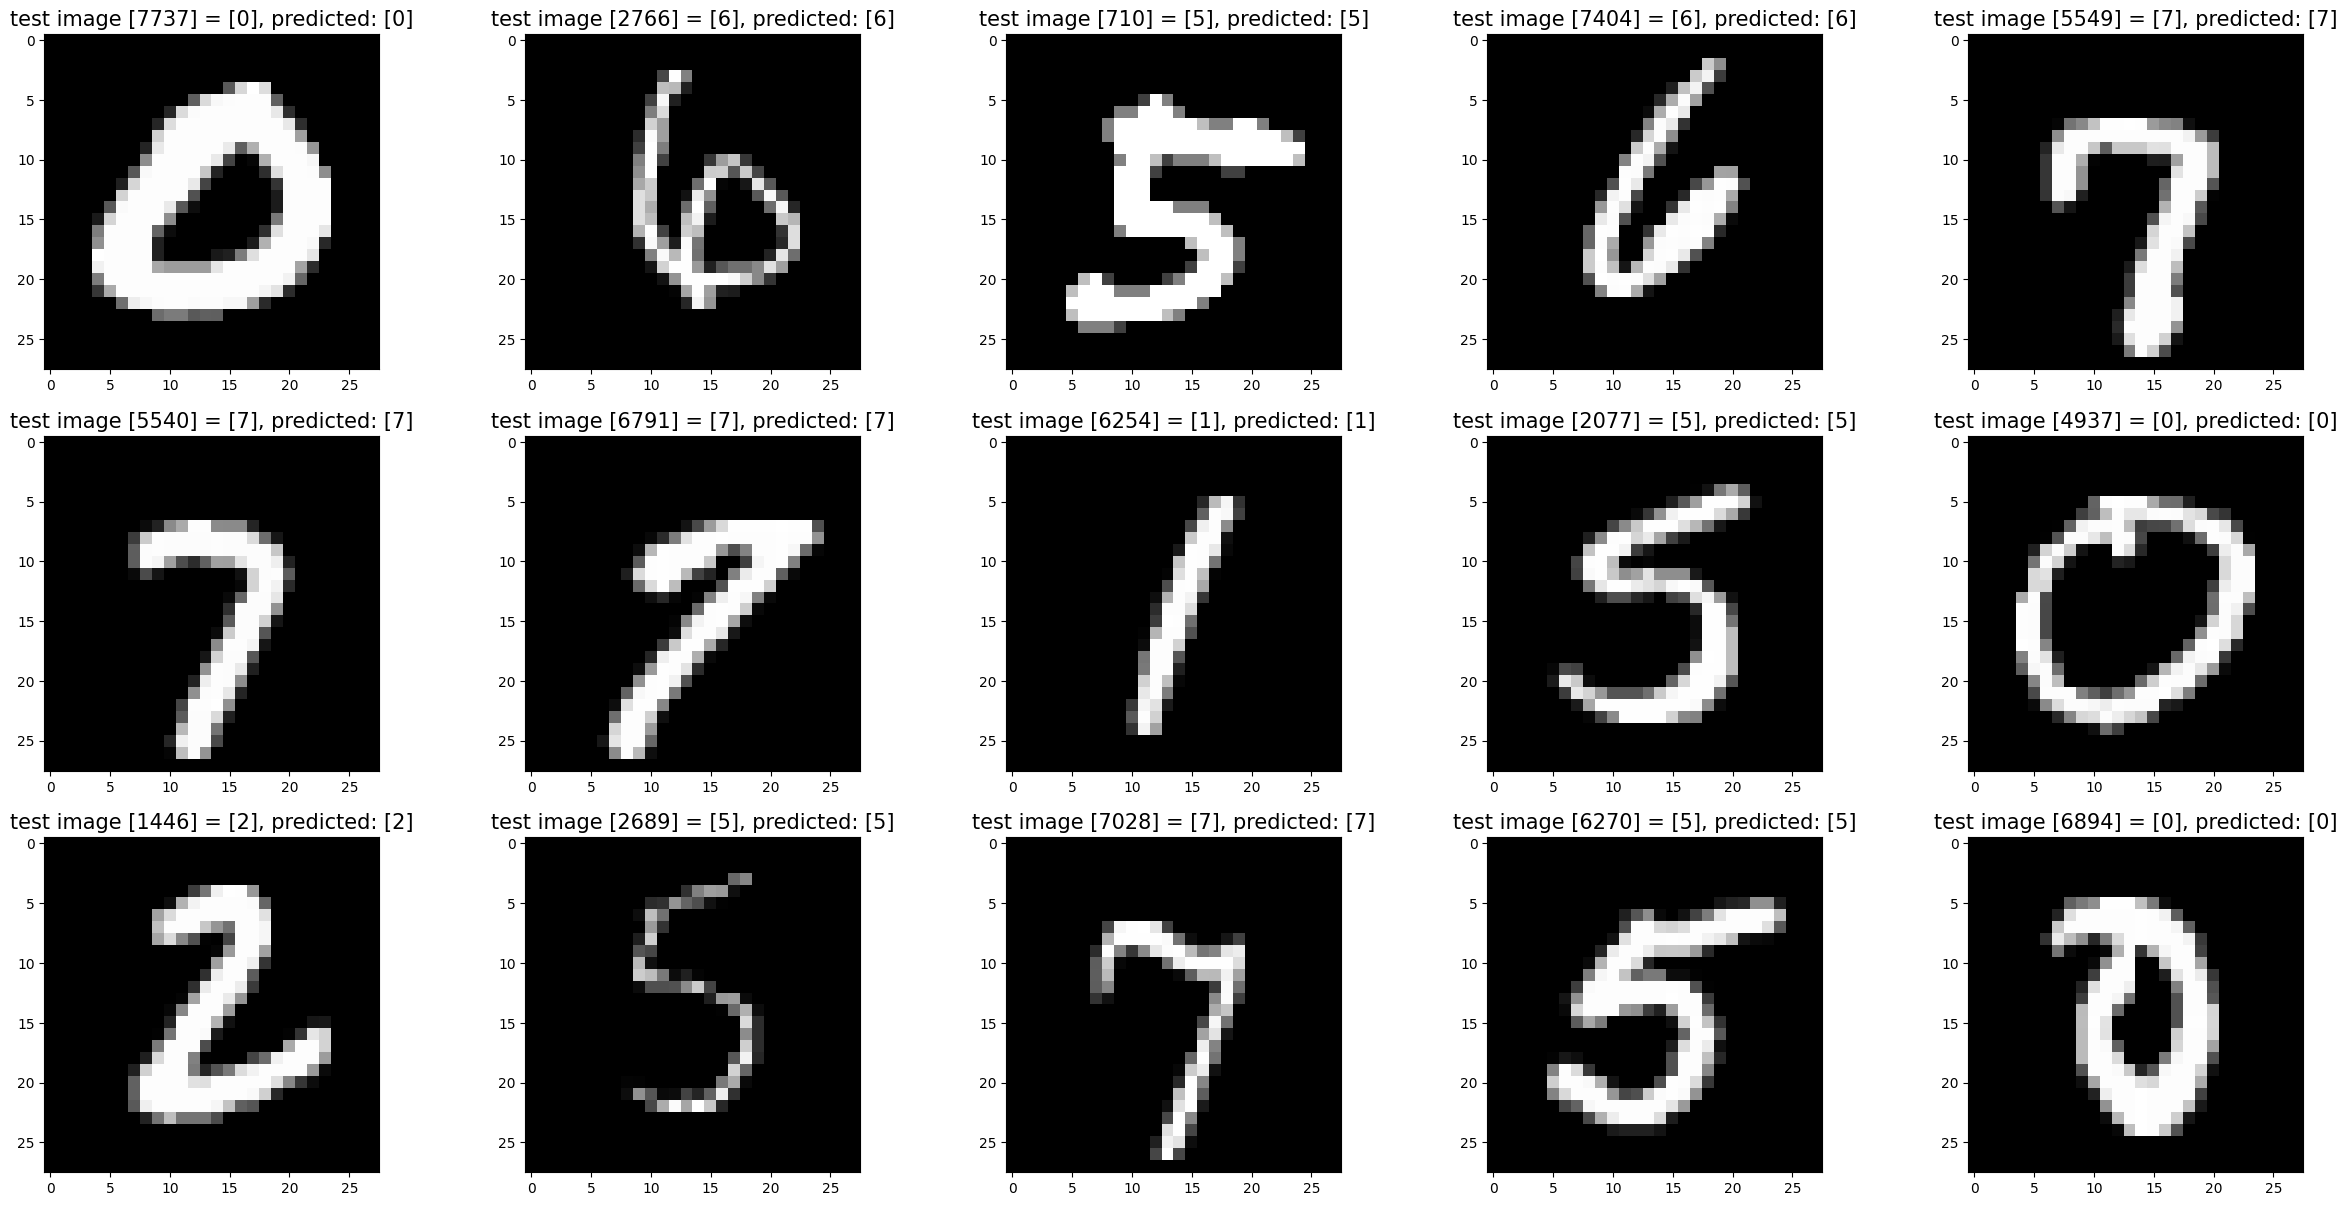

In [80]:
images_2_show = []
titles_2_show = []
for i in range(0, 15):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r].reshape(28, 28))
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]) + ', predicted: [' + str(y_test_pred[r]) + ']')

show_images(images_2_show, titles_2_show)

In [83]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
ml_cnf = multilabel_confusion_matrix(y_test, y_test_pred)
cnf = confusion_matrix(y_test, y_test_pred)

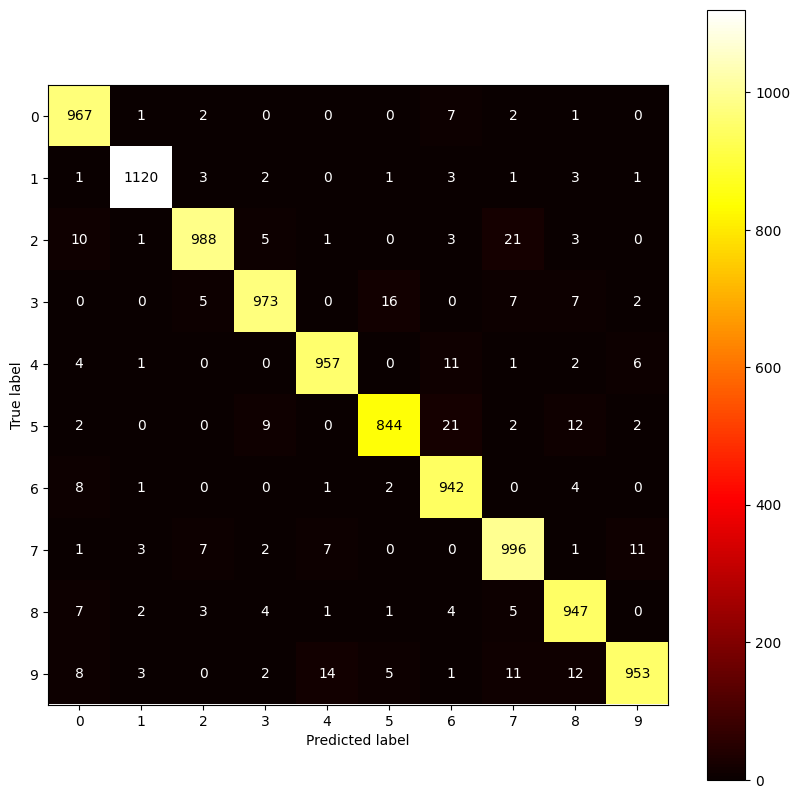

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(cnf, cmap='hot', interpolation='nearest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.xticks(np.arange(10), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.yticks(np.arange(10), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
for i in range(10):
    for j in range(10):
        if i == j:
            plt.text(j, i, cnf[i, j], ha='center', va='center', color='black')
        else:
            plt.text(j, i, cnf[i, j], ha='center', va='center', color='white')
plt.show()


In [101]:
lenet.save('../content/LeNet-5.keras')

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(lenet)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)